In [ ]:
import scipy.stats as sps
from tqdm.notebook import tqdm as tqdm_notebook 
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from matplotlib import pyplot as plt

В этом домашнем задании будем работать с купедом и стратификацией. Для начала сгенерируем выборку из $1000$ сэмплов экспоненциального распределения, это будут значения нашей метрики для $1000$ пользователей

In [ ]:
control_before = sps.expon(scale=1000).rvs(1000)

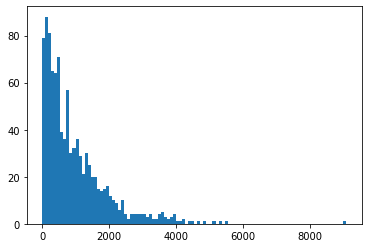

In [ ]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [ ]:
control = control_before + sps.norm(loc=0, scale=100).rvs(1000)

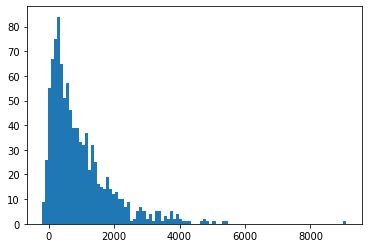

In [ ]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$

In [ ]:
sps.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf([0.025, 0.975])

array([ 892.05028145, 1010.96563257])

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = sps.expon(scale=1000).rvs(1000)
    control = control_before + sps.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = sps.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf([0.025, 0.975])
    
    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в 5.390000000000001% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = sps.expon(scale=1000).rvs(1000)
    control = control_before + sps.norm(loc=0, scale=100).rvs(1000)

    matrix_cov = np.cov([control, control_before])
    theta = matrix_cov[0, 1] / matrix_cov[1, 1]
    control_cuped = control - control_before * theta + control_before.mean() * theta

    mean = control_cuped.mean()
    std = control_cuped.std() / np.sqrt(len(control))
    
    left_bound, right_bound = sps.norm(loc=mean, scale=std).ppf([0.025, 0.975])
    
    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1
    
print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  84.11% случаев;


Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = sps.expon(scale=1000).rvs(1000 * 10)
    mean_full = control_before_full.mean()
    
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(range(samples_in_ab), samples_in_ab // 2, False)
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]
    
    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]
    
    control_after_a = control_before_a + sps.norm(loc=0, scale=100).rvs(samples_in_ab // 2)
    control_after_b = control_before_b + sps.norm(loc=0, scale=100).rvs(samples_in_ab // 2)

    matrix_cov = np.cov([control_after_a + control_after_b, control_before_a + control_before_b])
    theta = matrix_cov[0, 1] / matrix_cov[1, 1]

    control_cup_a = control_after_a + (mean_full - control_before_a) * theta
    contrul_cup_b = control_after_b + (mean_full - control_before_b) * theta
    
    if ks_2samp(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1
    
print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  70.49% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



Значение стат разницы 
 первом случае мы за матожидание принимаем среднее от control_before, и так как данных не очень много, то при добавлении   
tetta * mean(control_before) оценка все равно остается смещенной. А во втором случае мы берем среднее по всем данным, и поэтому значение получается более близким к матожиданию, поэтому оценка меньше смещена и результаты лучше. 

Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [ ]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = sps.expon(scale=1000).rvs(1000 * 10)
    mean_full = control_before_full.mean()
    
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(range(samples_in_ab), samples_in_ab // 2, False)
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]
    
    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]
    
    control_after_a = control_before_a + sps.norm(loc=0, scale=100).rvs(samples_in_ab // 2)
    control_after_b = control_before_b + sps.norm(loc=10, scale=100).rvs(samples_in_ab // 2)

    matrix_cov = np.cov([control_after_a + control_after_b, control_before_a + control_before_b])
    theta = matrix_cov[0, 1] / matrix_cov[1, 1]

    control_cup_a = control_after_a + (mean_full - control_before_a) * theta
    contrul_cup_b = control_after_b + (mean_full - control_before_b) * theta
    
    if ks_2samp(control_after_a,control_after_b).pvalue < 0.05:
        bad_cnt += 1
    
    if ks_2samp(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1
    
print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  5.949999999999999% случаев; при использовании CUPED -- в 70.81% случаев


# Уменьшение дисперсии

В этой части задания вам нужно применить методы уменьшения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: None -- пользователь не участвует в АБ тесте, *_before -- соответствующая группа до начала теста, *_after_i -- группа после начала эксперимента, чем больше i -- тем позже было сделано наблюдение.

В этом задании необходимо использовать тест Стьюдента, как это рассматривалось на лекции. Вы можете проводить тесты между control_before_i и tratment_before_i, без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие при уровне значимости $0.05$.

Тест Стьюдента необходимо написать самим, то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value.

Вам необходимо реализовать стратификацию и CUPED, далее сравнить результаты и описать в чем разница

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/kaggle/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(path + 'data_ab.csv')
data

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before
...,...,...,...
99995,old,7890.224384,treatment_after_5
99996,old,8165.046263,treatment_after_5
99997,old,10034.632118,treatment_after_5
99998,old,7564.445251,treatment_after_5


In [ ]:
data.groupby('age').count()

,metric,group
age,,
adult,45000,24000
old,35000,18000
young,20000,12000


In [ ]:
from scipy.stats import t

def t_test_student(x, y):
  x_mean = x.mean()
  y_mean = y.mean()

  sigma2_x = np.sum(np.square(x - x_mean)) / (len(x) - 1)
  sigma2_y = np.sum(np.square(y - y_mean)) / (len(y) - 1)
  sigma2 = sigma2_x / len(x) + sigma2_y / len(y)

  t_test = (x_mean - y_mean) / np.sqrt(sigma2)

  df = sigma2 / ((np.square(sigma2_x / len(x)) / (len(x) - 1)) + (np.square(sigma2_y / len(y)) / (len(y) - 1)))
  return 2 * (t.cdf(-abs(t_test), df))


In [ ]:
def get_group(data, group, age = None):
    if age:
        return data[(data['age'] == age) & (data['group'] == group)]['metric']
    return data[data['group'] == group]['metric']

In [ ]:
def t_test(x_mean, y_mean, x_s, y_s, len_x, len_y): 
    t_s = (x_mean - y_mean) / np.sqrt(x_s / len_x + y_s / len_y)
    
    dof1 = np.square(x_s / len_x + y_s / len_y)
    dof2 = np.square(x_s) / (np.square(len_x) * (len_x - 1))
    dof3 = np.square(y_s) / (np.square(len_y) * (len_y - 1))
    
    return 2 * (t.cdf(-abs(t_s), dof1 / (dof2 + dof3)))

**Стратификация**

In [ ]:
def strat_t_test(data, i):
    x_mean = 0
    y_mean = 0
    
    x_s = 0
    y_s = 0
    
    len_x = len(get_group(data, 'control_after_' + i))
    len_y = len(get_group(data, 'treatment_after_' + i))
    
    for age in list(data['age'].unique()):
        x = get_group(data, 'control_after_' + i, age)
        n_k = len(x) 
        w_k = n_k / len_x
        x_mean += x.mean() * w_k
        x_s += np.sum(np.square(x - x_mean)) / (n_k - 1) 
        
        y = get_group(data, 'treatment_after_' + i, age)
        n_k = len(y) 
        w_k = n_k / len_y
        y_mean += y.mean() * w_k 
        y_s += np.sum(np.square(y - y_mean)) / (n_k - 1)
    
    return t_test(x_mean, y_mean, x_s / len_x, y_s / len_y, len_x, len_y)      

**CUPED**

In [ ]:
mean = data[data['group'].isna()]['metric'].mean()
res = []
for i in range(1, 6):
    control, treatment = get_cuped_adjusted(np.array(get_group(data, 'control_before')),
                                            np.array(get_group(data, 'treatment_before')),
                                            np.array(get_group(data, 'control_after_' + str(i))),
                                            np.array(get_group(data, 'treatment_after_' + str(i))), mean)

    x_mean = control.mean()
    y_mean = treatment.mean()

    len_x = len(control)
    len_y = len(treatment)

    x_s = np.sum(np.square(control - x_mean)) / (len_x - 1)     
    y_s = np.sum(np.square(treatment - y_mean)) / (len_y - 1)

    res.append(t_test(x_mean, y_mean, x_s, y_s, len_x, len_y))

**Результаты**

In [ ]:
print("Без применения методов:")
for i in range(1, 6):
    print(simple_t_test(get_group(data, 'control_after_' + str(i)), get_group(data, 'treatment_after_' + str(i))))
    
print("\nСтратификация:")
for i in range(1, 6):
    print(strat_t_test(data, str(i)))
    
print("\nCUPED:")
for i in range(5):
    print(res[i - 1])

Без применения методов:
0.6922472245236946
0.40334947881906724
0.23366578804173935
0.12149349071629681
0.05381517048510022

Стратификация:
2.01802350889877e-17
5.326459247247116e-71
6.657222182041148e-140
4.204874279282738e-230
0.0

CUPED:
0.9167916620924192
0.9135115180850472
0.9143849321382695
0.9151536503443171
0.9160924462625428


**Мои мысли 2**

Результаты стратификации лучше, чем у CUPED